# Compose: Training a model to generate music

In [60]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, prepare_sequences_with_velocity, create_network_with_velocity

## Set parameters

In [78]:
# run params
section = 'compose'
run_id = 'GRU_add_velocity'
genre_name = 'jazz'
composer_name='JohnColtrane'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'load' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True
reg = None
learning_rate = 0.001

## Extract the notes

In [79]:
data_folder

'data/jazz/JohnColtrane'

In [81]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []
    velocities = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            #notes.extend(['START'] * seq_len)
            #durations.extend([0]* seq_len)
            #velocities.extend([0]* seq_len)
            notes.extend(['START'])
            durations.extend([0])
            velocities.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                        velocities.append(element.volume.velocity)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)
                        velocities.append(element.volume.velocity)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)
                    velocities.append(element.volume.velocity)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
    with open(os.path.join(store_folder, 'velocities'), 'wb') as f:
        pickle.dump(velocities, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 
    with open(os.path.join(store_folder, 'velocities'), 'rb') as f:
        velocities = pickle.load(f) 

## Create the lookup tables

In [82]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations, velocity_names, n_velocities]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration, velocity_to_int, int_to_velocity]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [83]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.B2': 1,
 'A2.F#3': 2,
 'A2.F3': 3,
 'A3': 4,
 'A3.B-3': 5,
 'A3.B3': 6,
 'A3.C#4': 7,
 'A3.C4': 8,
 'A3.D4': 9,
 'A3.E-4': 10,
 'A3.F4': 11,
 'A3.G4': 12,
 'A4': 13,
 'A4.B-4': 14,
 'A4.B-4.B4': 15,
 'A4.B-4.C5': 16,
 'A4.B4': 17,
 'A4.B4.C#5': 18,
 'A4.C#5': 19,
 'A4.C5': 20,
 'A4.D5': 21,
 'A4.E-5': 22,
 'A5': 23,
 'A5.B-5': 24,
 'A5.B5': 25,
 'A5.C6': 26,
 'B-2': 27,
 'B-2.B2': 28,
 'B-2.C3': 29,
 'B-2.D3': 30,
 'B-2.F#3': 31,
 'B-2.F#4': 32,
 'B-2.F3': 33,
 'B-3': 34,
 'B-3.B3': 35,
 'B-3.C#4': 36,
 'B-3.C4': 37,
 'B-3.D4': 38,
 'B-3.E-4': 39,
 'B-3.F#4': 40,
 'B-3.F#4.G4': 41,
 'B-3.F4': 42,
 'B-3.G#4': 43,
 'B-3.G4': 44,
 'B-4': 45,
 'B-4.B4': 46,
 'B-4.C#5': 47,
 'B-4.C5': 48,
 'B-4.D5': 49,
 'B-4.E-5': 50,
 'B-5': 51,
 'B-5.B5': 52,
 'B2': 53,
 'B2.B3': 54,
 'B2.C#3': 55,
 'B2.C#5': 56,
 'B2.C3': 57,
 'B2.C5': 58,
 'B2.D3': 59,
 'B2.F3': 60,
 'B2.G3': 61,
 'B3': 62,
 'B3.A4': 63,
 'B3.C#4': 64,
 'B3.C4': 65,
 'B3.C5': 66,
 'B3.D4': 67,
 'B3.E-4': 68,
 'B3.E4': 69

In [84]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(13, 12): 13,
 Fraction(7, 6): 14,
 1.25: 15,
 Fraction(4, 3): 16,
 Fraction(17, 12): 17,
 1.5: 18,
 Fraction(19, 12): 19,
 Fraction(5, 3): 20,
 1.75: 21,
 Fraction(11, 6): 22,
 Fraction(23, 12): 23,
 2.0: 24,
 Fraction(25, 12): 25,
 Fraction(13, 6): 26,
 2.25: 27,
 Fraction(7, 3): 28,
 Fraction(29, 12): 29,
 2.5: 30,
 Fraction(31, 12): 31,
 Fraction(8, 3): 32,
 2.75: 33,
 Fraction(17, 6): 34,
 Fraction(35, 12): 35,
 3.0: 36,
 Fraction(19, 6): 37,
 3.25: 38,
 Fraction(10, 3): 39,
 3.5: 40,
 Fraction(43, 12): 41,
 Fraction(11, 3): 42,
 3.75: 43,
 Fraction(23, 6): 44,
 4.0: 45,
 Fraction(49, 12): 46,
 4.25: 47,
 Fraction(13, 3): 48,
 Fraction(53, 12): 49,
 4.5: 50,
 Fraction(14, 3): 51,
 4.75: 52,
 5.0: 53,
 5.25: 54,
 5.5: 55,
 5.75: 56,
 6.0: 57,
 6.25: 58,
 Fraction(

## Prepare the sequences used by the Neural Network

In [85]:
network_input, network_output = prepare_sequences_with_velocity(notes, durations, velocities, lookups, distincts, seq_len)

KeyboardInterrupt: 

In [ ]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('velocity input')
print(network_input[2][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])
print('velocity output')
print(network_output[2][0])

## Create the structure of the neural network

In [ ]:
model, att_model = create_network_with_velocity(n_notes, n_durations, n_velocities, embed_size, rnn_units, use_attention, reg, learning_rate)
model.summary()

In [ ]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=1000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']




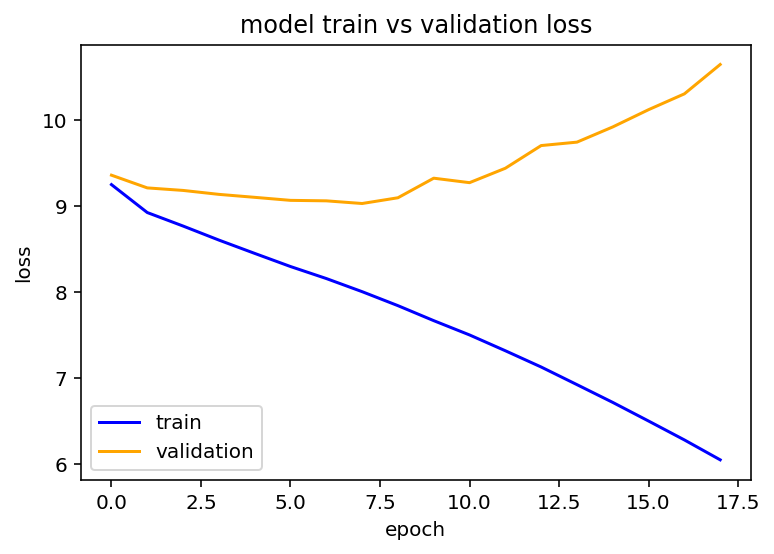

In [73]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()